# [How to use Detectron2 with Our Custom Marine COCO Datasets](https://www.dlology.com/blog/how-to-train-detectron2-with-custom-coco-datasets/)

<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

This notebook helped us get started with this detectron2 framwork using our Marine trained instance segmentation model from our custom Marine COCO model.

# Import detectron2 and other requirements:

In [1]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup
# Setup detectron2 logger
import detectron2
#from detectron2.utils.logger import setup_logger
#setup_logger()

# import some common libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import random

#from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog


#from detectron2.engine import DefaultTrainer

from detectron2 import model_zoo



Bad key "text.kerning_factor" on line 4 in
/Users/craig/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


# Use our custom Marine COCO dataset

In this section, we show how to use your Marine trained detectron2 model with our custom dataset in a new format.

For our training images we started from the [the marine segmentation dataset](https://github.com/Allopart/Maritme_Mask_RCNN)
which  has 5 classes: data, buoy, land, sea, ship and sky.

In this notebook we are presenting a segmentation model with weights from our new pre-trained COCO model, available from detectron2's model zoo.

Note that the COCO dataset did not have the "ship", "buoy" and "land" categories that we are training on from our model to predict these features.

If you need the dataset, then you can uncomment out the next few lines or download it directly from the AWS link shown in the README.md file.

In [2]:
# download, decompress the data
#!wget https://cbpetro.s3.us-east-2.amazonaws.com/api/download/data.zip
#!unzip data.zip > /dev/null

### Register the Nautical dataset to detectron2, following the [detectron2 custom dataset tutorial](https://detectron2.readthedocs.io/tutorials/datasets.html).


In [3]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("nautical_ecp", {}, "./data/trainval.json", "./data/images")

In [4]:
nautical_metadata = MetadataCatalog.get("nautical_ecp")
dataset_dicts = DatasetCatalog.get("nautical_ecp")


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



To verify the data loading is correct, let's visualize the annotations of randomly selected samples from the training set:



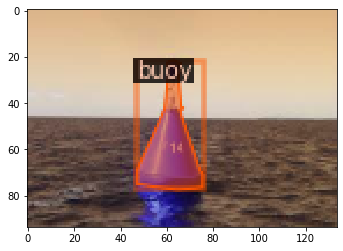

In [5]:
for d in random.sample(dataset_dicts, 1):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=nautical_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.show()


### Now, let's use coco-pretrained R50-FPN Mask R-CNN model with the weights of the Nautical dataset. 

In [6]:
cfg = get_cfg()
cfg.MODEL.DEVICE = "cpu"
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("nautical_ecp",)
#cfg.DATASETS.TEST = ()   # no metrics implemented for this dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5  # 5 classes (data, buoy, land, sea, ship, sky)


#os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
#trainer = DefaultTrainer(cfg)
#trainer.resume_or_load(resume=False)
#trainer.train()

### This is where we load our new weights from our Colab training from the nautical dataset. First, let's create a predictor using the model we just trained:

In [7]:
# Directory where output files are written
cfg.OUTPUT_DIR = "./output"
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("nautical_ecp", )
predictor = DefaultPredictor(cfg)

### Then, we randomly select several samples to visualize the prediction results.

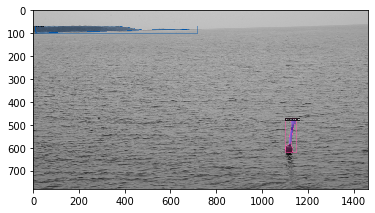

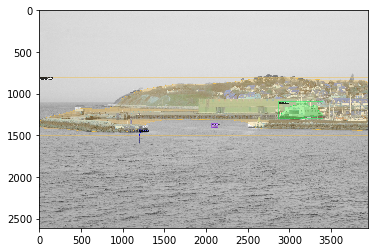

In [8]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(dataset_dicts, 2):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=nautical_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    #cv2_imshow(v.get_image()[:, :, ::-1])
    plt.imshow(v.get_image()[:, :, ::-1])
    plt.show()


The following images are being used for validation. They were downloaded from the web and never used in the training set. 

./data_val/images-2.jpeg


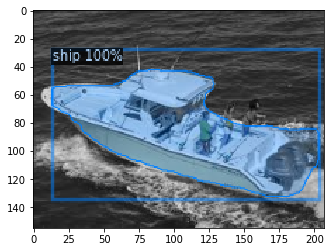

./data_val/images-3.jpeg


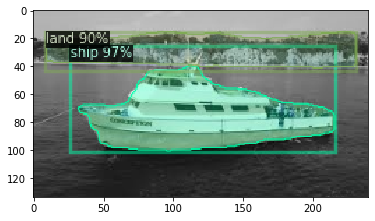

./data_val/images-4.jpeg


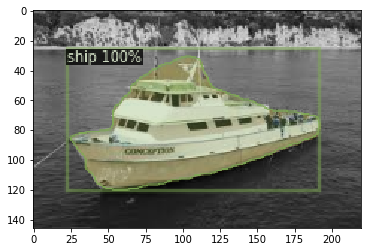

./data_val/images-5.jpeg


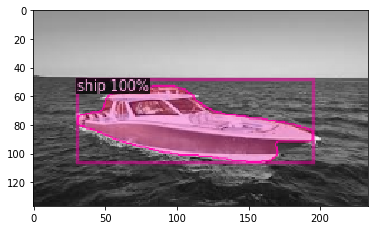

./data_val/images-6.jpeg


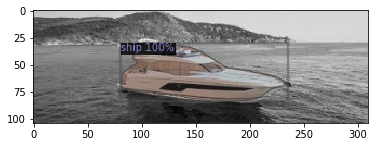

./data_val/images-7.jpeg


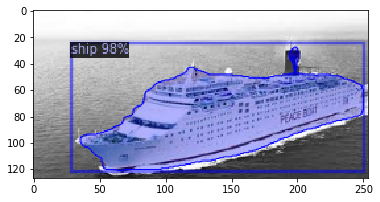

./data_val/images-8.jpeg


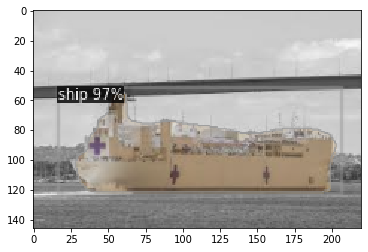

./data_val/images-9.jpeg


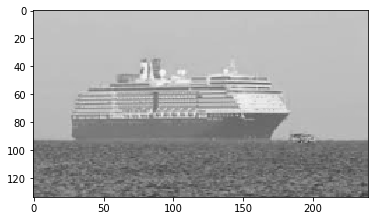

./data_val/images-10.jpeg


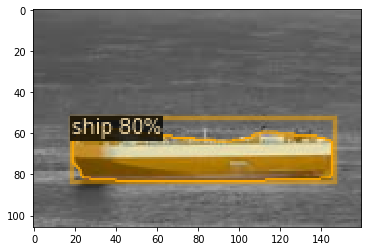

./data_val/images-11.jpeg


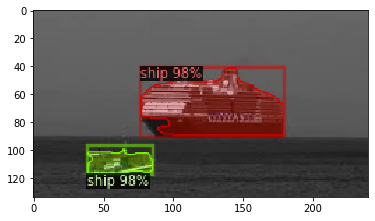

./data_val/images-12.jpeg


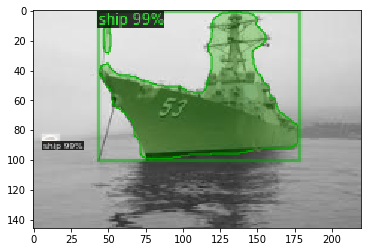

./data_val/images-13.jpeg


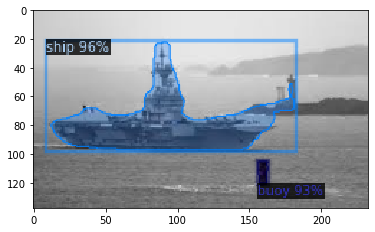

./data_val/images-14.jpeg


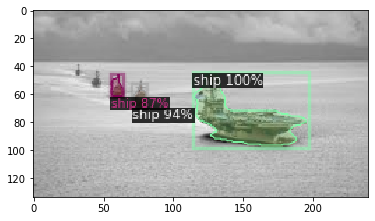

./data_val/images-15.jpeg


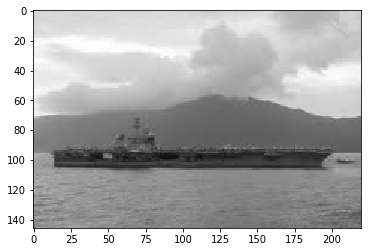

./data_val/images-16.jpeg


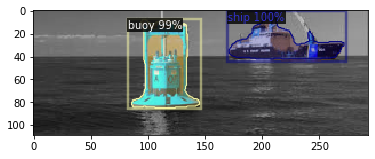

./data_val/images-17.jpeg


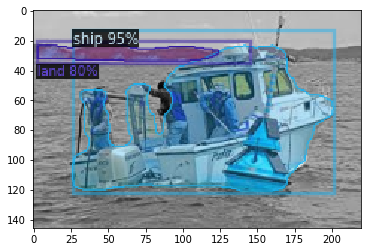

./data_val/images-18.jpeg


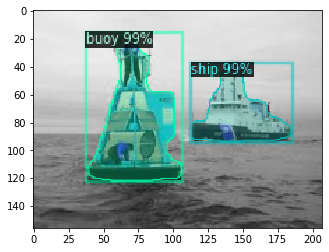

./data_val/images-19.jpeg


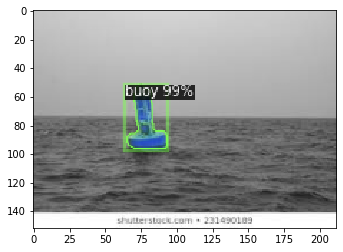

./data_val/images-20.jpeg


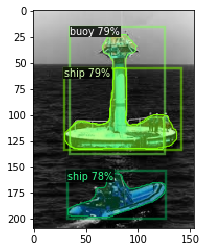

./data_val/images-21.jpeg


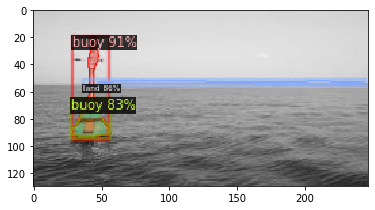

./data_val/images-22.jpeg


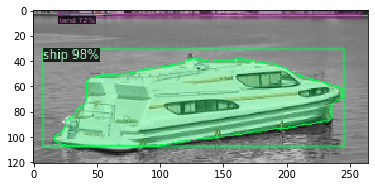

./data_val/images-23.jpeg


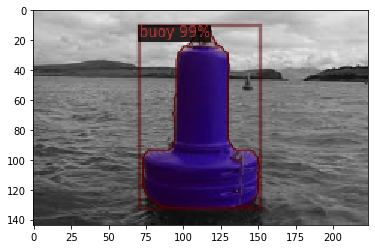

./data_val/images-24.jpeg


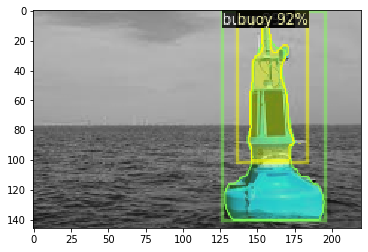

./data_val/images-25.jpeg


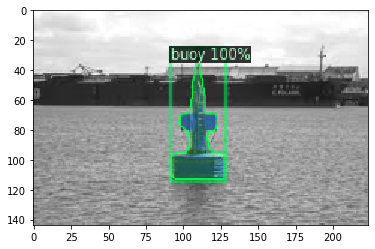

./data_val/images-26.jpeg


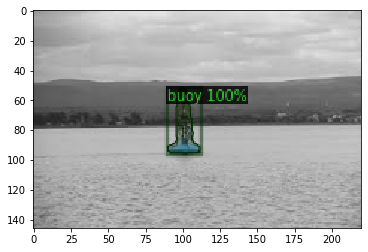

./data_val/images-27.jpeg


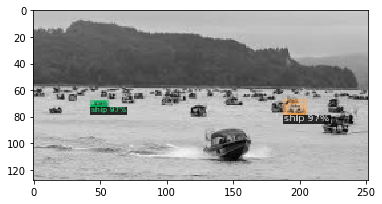

./data_val/images-28.jpeg


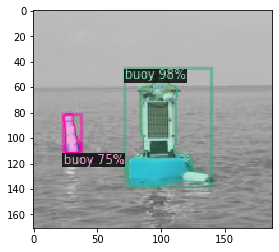

In [9]:
for i in range(2,29,1): 
    nautical_img_no = str(i)
    img = os.path.join("./data_val/images-" +nautical_img_no + ".jpeg") #1-24 in boats
    print(img)
    im  = cv2.imread(img)
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=nautical_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    #cv2_imshow(v.get_image()[:, :, ::-1])
    plt.imshow(v.get_image()[:, :, ::-1])
    plt.show()

### Nautical metadata:

In [10]:
nautical_metadata

Metadata(evaluator_type='coco', image_root='./data/images', json_file='./data/trainval.json', name='nautical_ecp', thing_classes=['buoy', 'land', 'ship'], thing_dataset_id_to_contiguous_id={0: 0, 1: 1, 2: 2})

### This is an example of reading in a single image from our validation set. 

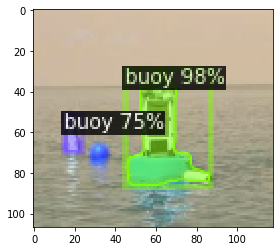

In [11]:
im = cv2.imread("./data_val/images-28.jpeg")
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1],
               metadata=nautical_metadata,
               scale=0.8,
               )
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(v.get_image()[:, :, ::-1])
plt.show()

## Benchmark inference speed:

In [12]:
import time
times = []
for i in range(20):
    start_time = time.time()
    outputs = predictor(im)
    delta = time.time() - start_time
    times.append(delta)
mean_delta = np.array(times).mean()
fps = 1 / mean_delta
print("Average(sec):{:.2f},fps:{:.2f}".format(mean_delta, fps))

Average(sec):4.46,fps:0.22
